In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch

if torch.cuda.is_available():
    print(f"Currently using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU detected. Ensure CUDA is properly installed.")


Currently using GPU: NVIDIA A100-SXM4-40GB


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna

# ====================================================
# Step 1: Load and Inspect the CSV File
# ====================================================
df = pd.read_csv("dataset.csv", encoding="latin1")
print("CSV Columns:", df.columns.tolist())

# Define column names based on your dataset
TEXT_COL = "Text"    # The column with the text
LABEL_COL = "Label"  # The column with labels ("hate", "non-hate")

# Verify required columns exist
if TEXT_COL not in df.columns:
    raise KeyError(f"Column '{TEXT_COL}' not found in CSV.")
if LABEL_COL not in df.columns:
    raise KeyError(f"Column '{LABEL_COL}' not found in CSV.")

# ====================================================
# Step 2: Data Cleaning and Label Mapping
# ====================================================
def clean_text(text):
    # Basic cleaning: lower case, remove extra whitespace.
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df[TEXT_COL] = df[TEXT_COL].apply(clean_text)

# Drop rows where LABEL_COL is missing or not one of our expected values.
df = df[df[LABEL_COL].isin(["hate", "non-hate"])]
print("After filtering invalid labels, dataset shape:", df.shape)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
df[LABEL_COL] = df[LABEL_COL].map(label_map).astype("int64")

# ====================================================
# Step 3: Train-Test Split
# ====================================================
# Stratified split by label to preserve distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[LABEL_COL])

# ====================================================
# Step 4: Convert to Hugging Face Dataset
# ====================================================
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# ====================================================
# Step 5: Tokenization
# ====================================================
# Load the tokenizer from Indic‑BERT.
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

def tokenize_function(example):
    return tokenizer(example[TEXT_COL], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Keep only tokenized inputs and the label column
cols_to_keep = ["input_ids", "attention_mask", LABEL_COL]
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in cols_to_keep]
)
# Rename label column to "labels" as expected by Trainer
tokenized_datasets = tokenized_datasets.rename_column(LABEL_COL, "labels")
tokenized_datasets.set_format("torch")

# ====================================================
# Step 6: Model Definition and Metrics
# ====================================================
def model_init():
    # Load Indic-BERT for sequence classification (adds a classification head)
    model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2)
    # Ensure the model uses single-label classification (i.e. CrossEntropyLoss)
    model.config.problem_type = "single_label_classification"
    return model

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ====================================================
# Step 7: Training Arguments & Early Stopping
# ====================================================
# Updated result directory to "./results_INDIC"
training_args = TrainingArguments(
    output_dir='./results_INDIC',
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-5,  # initial value; will be tuned
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # maximum epochs (early stopping may halt earlier)
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    weight_decay=0.01
)

# ====================================================
# Step 8: Hyperparameter Tuning using Optuna
# ====================================================
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10)
    }

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting hyperparameter search...")
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    n_trials=10, 
    compute_objective=lambda metrics: metrics["eval_accuracy"]
)
print("Best hyperparameters found:", best_run.hyperparameters)

# Update training arguments with best hyperparameters
training_args.learning_rate = best_run.hyperparameters.get("learning_rate", training_args.learning_rate)
training_args.per_device_train_batch_size = best_run.hyperparameters.get("per_device_train_batch_size", training_args.per_device_train_batch_size)
training_args.num_train_epochs = best_run.hyperparameters.get("num_train_epochs", training_args.num_train_epochs)

# ====================================================
# Step 9: Final Training with Best Hyperparameters
# ====================================================
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting final training...")
trainer.train()

# ====================================================
# Step 10: Evaluation
# ====================================================
eval_results = trainer.evaluate()
print("Final evaluation results:", eval_results)


2025-03-28 11:05:05.243985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743140105.261037 2802791 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743140105.266259 2802791 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743140105.278582 2802791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743140105.278596 2802791 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743140105.278598 2802791 computation_placer.cc:177] computation placer alr

CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
After filtering invalid labels, dataset shape: (1599, 7)


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

/home/srmist20/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

[I 2025-03-28 11:05:16,343] A new study created in memory with name: no-name-754b6d44-e19d-48a5-9638-80216d36b082
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting hyperparameter search...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.689000,0.687850,0.728125,0.744157,0.728125,0.723587
100,0.666800,0.664338,0.793750,0.793796,0.793750,0.793742
150,0.604200,0.605537,0.862500,0.868254,0.862500,0.861961
200,0.493200,0.528809,0.853125,0.880616,0.853125,0.850424
250,0.434500,0.484157,0.881250,0.897135,0.881250,0.880051
300,0.443500,0.437786,0.915625,0.918387,0.915625,0.915486
350,0.412600,0.420252,0.931250,0.932941,0.931250,0.931183
400,0.405700,0.408271,0.943750,0.944028,0.943750,0.943741
450,0.398400,0.401204,0.943750,0.943819,0.943750,0.943748
500,0.385300,0.400700,0.937500,0.938116,0.937500,0.937478


[I 2025-03-28 11:06:17,365] Trial 0 finished with value: 0.94375 and parameters: {'learning_rate': 2.736810140612751e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 7}. Best is trial 0 with value: 0.94375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.684200,0.683007,0.700000,0.750784,0.700000,0.684003
100,0.633100,0.631194,0.806250,0.831305,0.806250,0.802516
150,0.514200,0.524953,0.878125,0.883533,0.878125,0.877694
200,0.395800,0.473398,0.878125,0.897128,0.878125,0.876649
250,0.398900,0.425161,0.928125,0.929484,0.928125,0.928068
300,0.411200,0.408669,0.934375,0.934800,0.934375,0.934359
350,0.385700,0.400968,0.946875,0.947032,0.946875,0.946870
400,0.380800,0.395830,0.943750,0.944028,0.943750,0.943741


[I 2025-03-28 11:07:02,208] Trial 1 finished with value: 0.94375 and parameters: {'learning_rate': 3.995487438864772e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5}. Best is trial 0 with value: 0.94375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.415000,0.458745,0.818750,0.853247,0.818750,0.814214
100,0.496100,0.186499,0.934375,0.937262,0.934375,0.934267
150,0.568500,0.456403,0.890625,0.910256,0.890625,0.889301
200,0.002100,0.126480,0.975000,0.975669,0.975000,0.974991
250,1.472000,0.199937,0.946875,0.950837,0.946875,0.946758
300,0.367500,0.106720,0.975000,0.976190,0.975000,0.974984
350,0.001500,0.120767,0.981250,0.981928,0.981250,0.981243
400,0.001400,0.167799,0.968750,0.969043,0.968750,0.968745
450,0.317000,0.242004,0.953125,0.957143,0.953125,0.953022
500,0.151000,0.222367,0.943750,0.949438,0.943750,0.943571


[I 2025-03-28 11:07:34,176] Trial 2 finished with value: 0.94375 and parameters: {'learning_rate': 4.150237063033752e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 4}. Best is trial 0 with value: 0.94375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.690500,0.689280,0.753125,0.753372,0.753125,0.753065
100,0.677100,0.675201,0.750000,0.751929,0.750000,0.749521
150,0.634800,0.638265,0.800000,0.802315,0.800000,0.799616
200,0.575600,0.590274,0.865625,0.873340,0.865625,0.864927
250,0.509700,0.535013,0.871875,0.881181,0.871875,0.871088
300,0.490300,0.495271,0.890625,0.892480,0.890625,0.890496
350,0.459700,0.471732,0.900000,0.904040,0.900000,0.899749
400,0.450700,0.459826,0.896875,0.902552,0.896875,0.896510
450,0.450000,0.452177,0.915625,0.918387,0.915625,0.915486


[I 2025-03-28 11:08:25,656] Trial 3 finished with value: 0.915625 and parameters: {'learning_rate': 2.337621621185419e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}. Best is trial 0 with value: 0.94375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.432800,0.393853,0.940625,0.941056,0.940625,0.940611
100,0.224600,0.154491,0.946875,0.950837,0.946875,0.946758
150,0.047500,0.126899,0.965625,0.967103,0.965625,0.965598
200,0.036300,0.103745,0.978125,0.978144,0.978125,0.978125


[I 2025-03-28 11:08:54,455] Trial 4 finished with value: 0.978125 and parameters: {'learning_rate': 2.8205191437757477e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 4 with value: 0.978125.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.689200,0.688016,0.693750,0.742947,0.693750,0.677419


[I 2025-03-28 11:08:59,348] Trial 5 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.690000,0.689136,0.637500,0.745057,0.637500,0.592822


[I 2025-03-28 11:09:03,324] Trial 6 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.692300,0.692506,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 11:09:08,708] Trial 7 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.483600,0.424293,0.946875,0.947732,0.946875,0.946850
100,0.136200,0.194509,0.953125,0.956136,0.953125,0.953048
150,0.151400,0.165712,0.959375,0.959824,0.959375,0.959365
200,0.022500,0.144323,0.971875,0.971893,0.971875,0.971875
250,0.436400,0.142215,0.959375,0.962428,0.959375,0.959308
300,0.423900,0.261284,0.937500,0.941919,0.937500,0.937343
350,0.217900,0.207747,0.956250,0.958039,0.956250,0.956207


[I 2025-03-28 11:09:30,008] Trial 8 finished with value: 0.95625 and parameters: {'learning_rate': 2.4657525189948464e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 6}. Best is trial 4 with value: 0.978125.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.693600,0.691944,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 11:09:35,696] Trial 9 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Best hyperparameters found: {'learning_rate': 2.8205191437757477e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting final training...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.432800,0.393853,0.940625,0.941056,0.940625,0.940611
100,0.224600,0.154491,0.946875,0.950837,0.946875,0.946758
150,0.047500,0.126899,0.965625,0.967103,0.965625,0.965598
200,0.036300,0.103745,0.978125,0.978144,0.978125,0.978125


Final evaluation results: {'eval_loss': 0.10374520719051361, 'eval_accuracy': 0.978125, 'eval_precision': 0.9781436774874018, 'eval_recall': 0.978125, 'eval_f1': 0.978124786374867, 'eval_runtime': 0.5526, 'eval_samples_per_second': 579.112, 'eval_steps_per_second': 72.389, 'epoch': 3.0}


In [4]:
trainer.save_model("./results_INDIC")
tokenizer.save_pretrained("./results_INDIC")


('./results_INDIC/tokenizer_config.json',
 './results_INDIC/special_tokens_map.json',
 './results_INDIC/spiece.model',
 './results_INDIC/added_tokens.json',
 './results_INDIC/tokenizer.json')

In [5]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

saved_model_dir = "./results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved tokenizer not found. Loading tokenizer and model from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
    model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()


Loading tokenizer and model from saved directory: ./results_INDIC


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features

In [6]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
test_df = pd.read_csv("Data final.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer from ./results_INDIC
# ------------------------------------------
saved_model_dir = "./results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    raise EnvironmentError(f"Saved model/tokenizer not found in {saved_model_dir}.")

# Ensure the model uses CrossEntropyLoss for single-label classification.
model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (467, 7)
Loading tokenizer and model from saved directory: ./results_INDIC

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.51      0.94      0.66       231
        hate       0.67      0.13      0.22       236

    accuracy                           0.53       467
   macro avg       0.59      0.53      0.44       467
weighted avg       0.59      0.53      0.44       467

Confusion Matrix:
[[216  15]
 [205  31]]


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer from ./results_INDIC
# ------------------------------------------
saved_model_dir = "./results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    raise EnvironmentError(f"Saved model/tokenizer not found in {saved_model_dir}.")

# Ensure the model uses CrossEntropyLoss for single-label classification.
model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Loading tokenizer and model from saved directory: ./results_INDIC


2025-03-28 11:53:35.068446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743143015.085637 2832695 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743143015.091275 2832695 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743143015.104690 2832695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143015.104702 2832695 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143015.104704 2832695 computation_placer.cc:177] computation placer alr


Classification Report:
              precision    recall  f1-score   support

    non-hate       0.75      0.84      0.79        50
        hate       0.82      0.72      0.77        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

Confusion Matrix:
[[42  8]
 [14 36]]


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------
# Step 1: Load and Prepare the Fine-Tuned Model & Tokenizer
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_dir = "results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)
model.config.problem_type = "single_label_classification"
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode!")

# ------------------------------------------------------
# Step 2: Define Refined Prompt Templates
# ------------------------------------------------------
# High-quality prompts aimed at achieving higher accuracy
prompt_templates = {
    "zero_shot": (
        "You are an expert in analyzing online content in Hinglish (a mix of Hindi and English). "
        "Please classify the following text as either 'Hate Speech' or 'Non-Hate Speech'.\n\n"
        "Text: \"{text}\"\n\n"
        "Answer:"
    ),
    "few_shot": (
        "Below are examples of classifying Hinglish texts:\n\n"
        "Example 1:\n"
        "Text: \"Tum log bohot badtameez ho, sabka dimag kharab kar dete ho\"\n"
        "Classification: Hate Speech\n\n"
        "Example 2:\n"
        "Text: \"I love spending time with my family and friends\"\n"
        "Classification: Non-Hate Speech\n\n"
        "Now, classify the following text accordingly:\n"
        "Text: \"{text}\"\n\n"
        "Answer:"
    ),
    "chain_of_thought": (
        "Analyze the following Hinglish text step by step and provide your reasoning before giving the final classification.\n"
        "Consider both Hindi and English parts, cultural nuances, and slang. If the text includes insults or promotes harm, classify it as 'Hate Speech'; otherwise, classify it as 'Non-Hate Speech'.\n\n"
        "Text: \"{text}\"\n\n"
        "Reasoning: [Briefly explain your thought process here]\n\n"
        "Final Classification (Answer only 'Hate Speech' or 'Non-Hate Speech'):"
    )
}

def classify_with_prompt(prompt_key, text):
    """
    Classify a given text using a specified prompting strategy.
    Returns the predicted label and the prompt used.
    """
    template = prompt_templates.get(prompt_key)
    if not template:
        raise ValueError("Invalid prompt key. Choose from: zero_shot, few_shot, chain_of_thought.")
    prompt_text = template.format(text=text)
    inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    label_map = {0: "Non-Hate Speech", 1: "Hate Speech"}
    predicted_label = label_map.get(predicted_class, "Unknown")
    return predicted_label, prompt_text

# ------------------------------------------------------
# Step 3: Load and Preprocess the Test Dataset
# ------------------------------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)
label_map_csv = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map_csv)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------------------
# Step 4: Evaluate Model Using Ensemble of Prompting Strategies on the Test Dataset
# ------------------------------------------------------
all_preds = []
all_labels = []

# Use all prompting strategies
prompt_keys = ["zero_shot", "few_shot", "chain_of_thought"]

for idx, row in test_df.iterrows():
    text = row["Text"]
    true_label = row["Label"]
    
    # Collect predictions from each prompt strategy
    strategy_preds = []
    for key in prompt_keys:
        pred_label, _ = classify_with_prompt(key, text)
        pred_numeric = 1 if pred_label == "Hate Speech" else 0
        strategy_preds.append(pred_numeric)
    
    # Ensemble via majority vote
    final_prediction = int(np.round(np.mean(strategy_preds)))  
    all_preds.append(final_prediction)
    all_labels.append(true_label)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Loading tokenizer and model from saved directory.
Model loaded and set to evaluation mode!
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.50      1.00      0.67        50
        hate       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

Confusion Matrix:
[[50  0]
 [50  0]]


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Load your saved model and tokenizer
# ------------------------------
saved_model_dir = "./results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------
# Load and preprocess the test CSV
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Define prompting functions
# ------------------------------
def zero_shot_prompt(text):
    # Zero-shot: simply prepend an instruction.
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text, examples):
    # Few-shot: include a few examples in the prompt.
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: {ex_text}\nLabel: {ex_label}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    # Chain-of-thought: instruct the model to think step by step.
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# Define a few-shot example list (tweak these examples as needed)
few_shot_examples = [
    ("i hate when people are rude", "hate"),
    ("i love when people are kind", "non-hate")
]

# ------------------------------
# Function to run inference with a given prompt function
# ------------------------------
def run_prompt_inference(df, prompt_func, **kwargs):
    all_preds = []
    all_labels = []
    for idx, row in df.iterrows():
        original_text = row["Text"]
        true_label = int(row["Label"])
        # Create the prompt using the provided function (pass additional arguments if needed)
        if kwargs:
            prompt_text = prompt_func(original_text, **kwargs)
        else:
            prompt_text = prompt_func(original_text)
        # Tokenize the prompt
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=-1)[0]
        all_preds.append(pred)
        all_labels.append(true_label)
    return all_preds, all_labels

# ------------------------------
# Run inference for each prompting technique
# ------------------------------
zero_preds, zero_labels = run_prompt_inference(test_df, zero_shot_prompt)
few_preds, few_labels = run_prompt_inference(test_df, few_shot_prompt, examples=few_shot_examples)
cot_preds, cot_labels = run_prompt_inference(test_df, chain_of_thought_prompt)

# ------------------------------
# Evaluate and visualize results
# ------------------------------
print("Zero-Shot Prompting Results:")
print(classification_report(zero_labels, zero_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(zero_labels, zero_preds))

print("\nFew-Shot Prompting Results:")
print(classification_report(few_labels, few_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(few_labels, few_preds))

print("\nChain-of-Thought Prompting Results:")
print(classification_report(cot_labels, cot_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(cot_labels, cot_preds))


Loading tokenizer and model from saved directory: ./results_INDIC
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Zero-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.63      0.98      0.77        50
        hate       0.95      0.42      0.58        50

    accuracy                           0.70       100
   macro avg       0.79      0.70      0.67       100
weighted avg       0.79      0.70      0.67       100

Confusion Matrix:
[[49  1]
 [29 21]]

Few-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.51      1.00      0.67        50
        hate       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100

Confusion Matrix:
[[50  0]
 [49  1]]

Chain

Loading tokenizer and model from saved directory: ./results_INDIC
Using device: cuda

---- EVALUATION ON TRAIN DATA ----

Zero-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.83      1.00      0.91       800
        hate       1.00      0.79      0.88       799

    accuracy                           0.90      1599
   macro avg       0.91      0.90      0.89      1599
weighted avg       0.91      0.90      0.89      1599



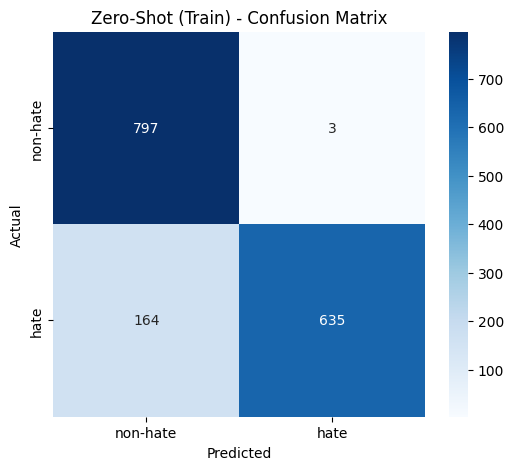

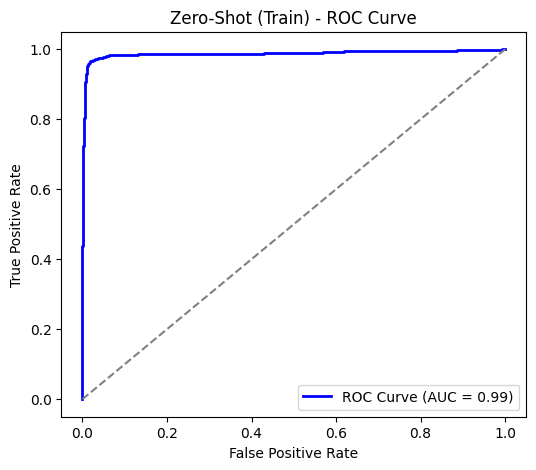

Zero-Shot (Train) Accuracy: 0.8956

Few-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.61      0.99      0.76       800
        hate       0.99      0.36      0.53       799

    accuracy                           0.68      1599
   macro avg       0.80      0.68      0.64      1599
weighted avg       0.80      0.68      0.64      1599



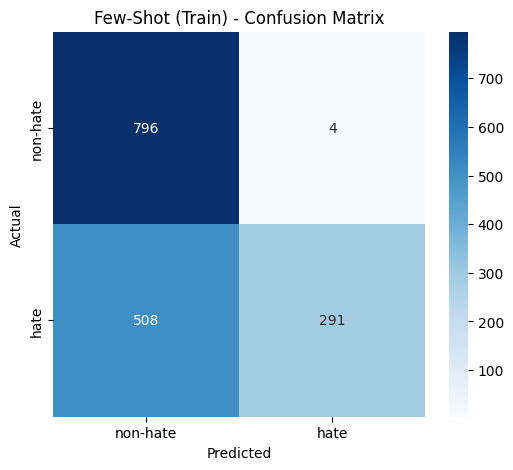

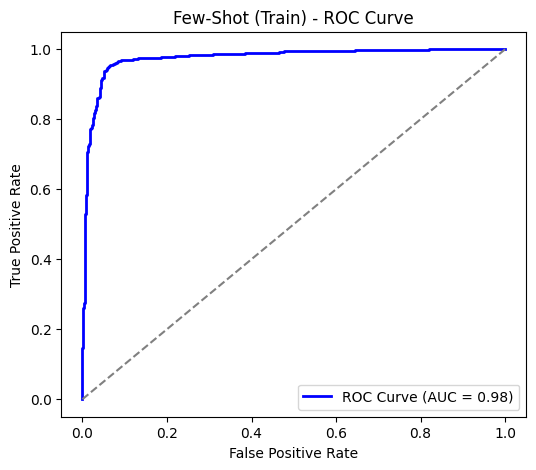

Few-Shot (Train) Accuracy: 0.6798

Chain-of-Thought (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.82      0.99      0.90       800
        hate       0.99      0.78      0.87       799

    accuracy                           0.89      1599
   macro avg       0.90      0.89      0.89      1599
weighted avg       0.90      0.89      0.89      1599



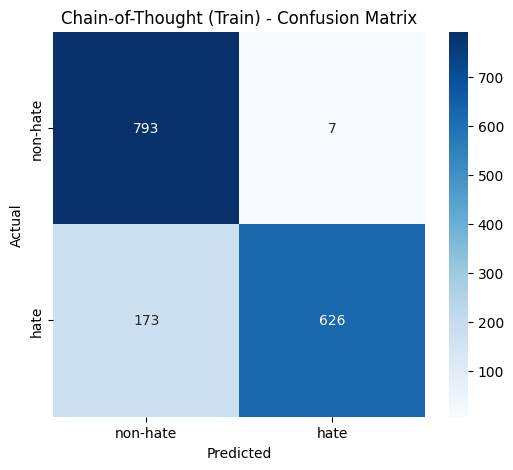

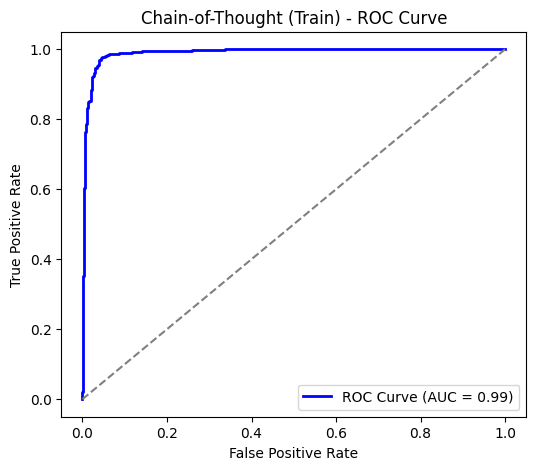

Chain-of-Thought (Train) Accuracy: 0.8874

Combined Prompting (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.63      0.99      0.77       800
        hate       0.98      0.41      0.58       799

    accuracy                           0.70      1599
   macro avg       0.80      0.70      0.68      1599
weighted avg       0.80      0.70      0.68      1599



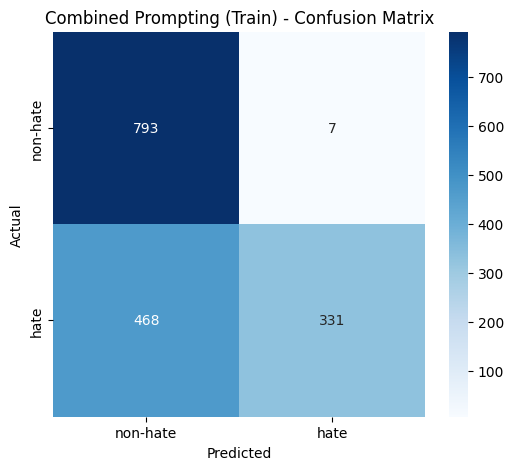

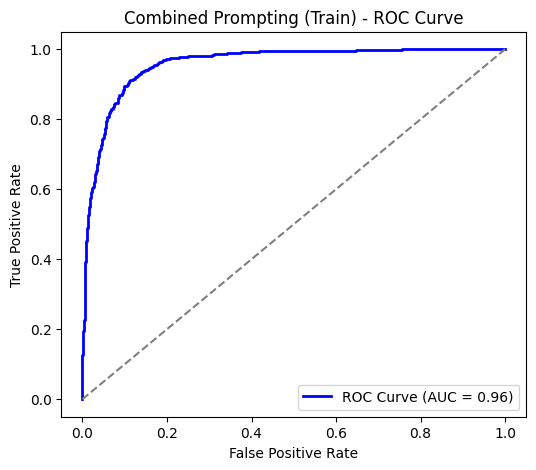

Combined Prompting (Train) Accuracy: 0.7029

---- EVALUATION ON TEST DATA ----

Zero-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.63      0.98      0.77        50
        hate       0.95      0.42      0.58        50

    accuracy                           0.70       100
   macro avg       0.79      0.70      0.67       100
weighted avg       0.79      0.70      0.67       100



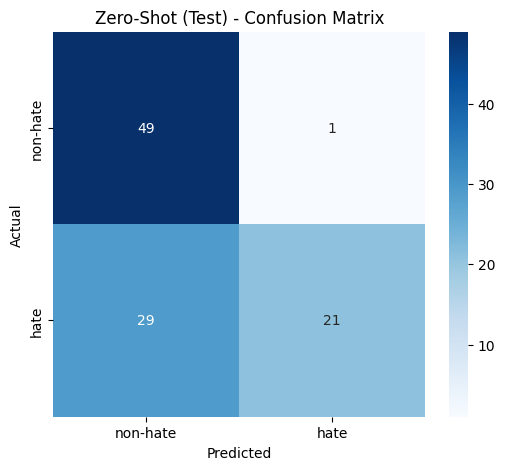

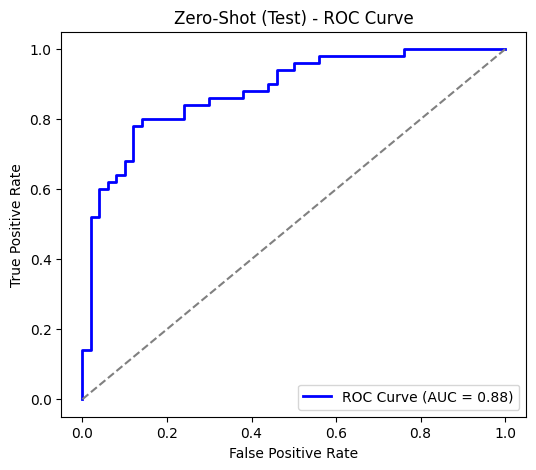

Zero-Shot (Test) Accuracy: 0.7000

Few-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.58      0.92      0.71        50
        hate       0.81      0.34      0.48        50

    accuracy                           0.63       100
   macro avg       0.70      0.63      0.60       100
weighted avg       0.70      0.63      0.60       100



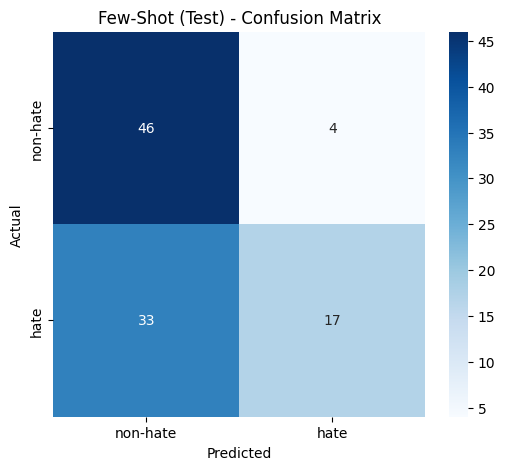

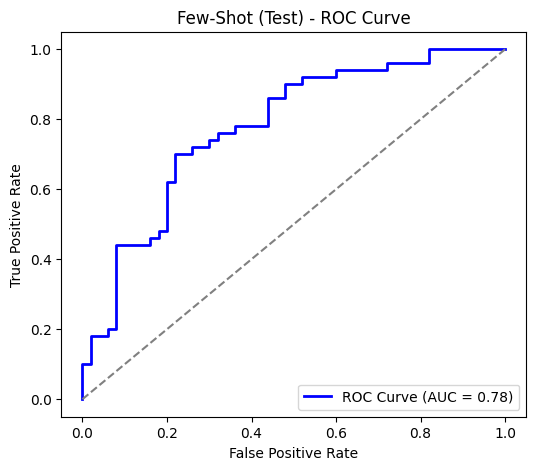

Few-Shot (Test) Accuracy: 0.6300

Chain-of-Thought (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.62      0.94      0.75        50
        hate       0.88      0.42      0.57        50

    accuracy                           0.68       100
   macro avg       0.75      0.68      0.66       100
weighted avg       0.75      0.68      0.66       100



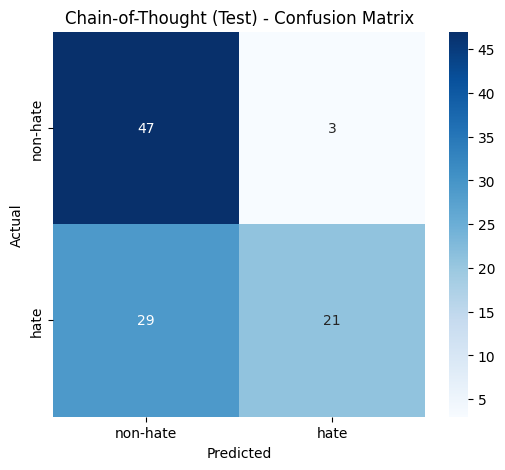

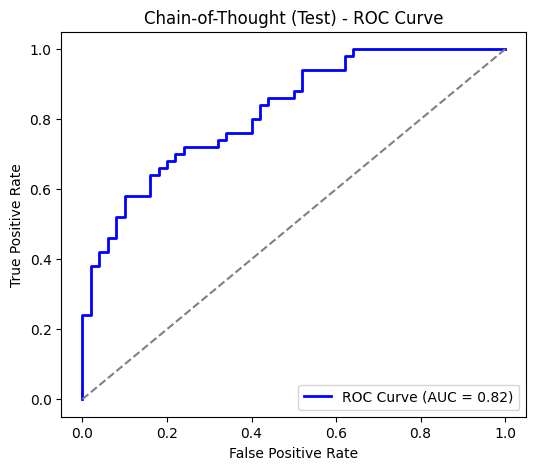

Chain-of-Thought (Test) Accuracy: 0.6800

Combined Prompting (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.56      0.96      0.71        50
        hate       0.86      0.24      0.38        50

    accuracy                           0.60       100
   macro avg       0.71      0.60      0.54       100
weighted avg       0.71      0.60      0.54       100



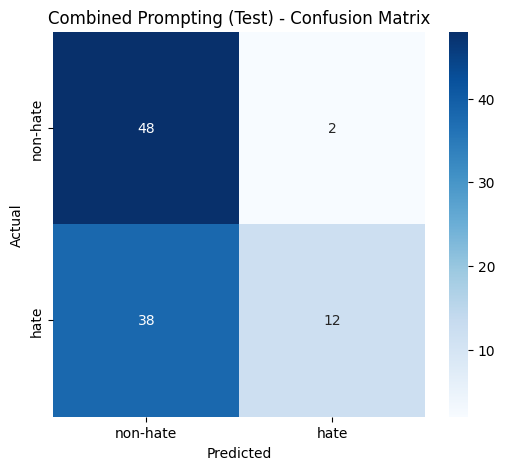

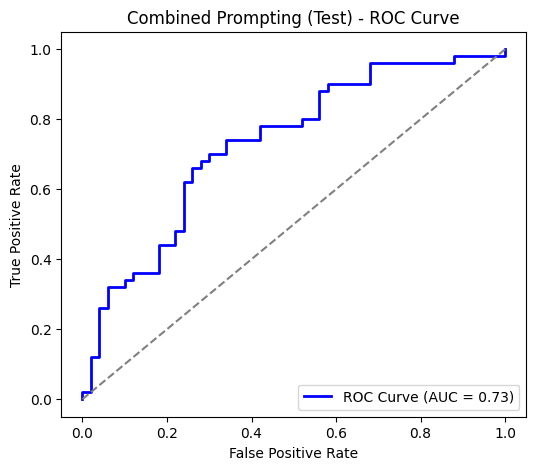

Combined Prompting (Test) Accuracy: 0.6000

🧠 LIME Explanation for Test Sample 5:
Text: ye movie bilkul bakwas thi, time waste mat karo.



In [6]:
import os
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer
import shap

# ------------------------------
# Load and Preprocess Dataset
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    # Data Cleaning
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    
    # Convert labels: "hate" -> 1, "non-hate" -> 0
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    
    return df

train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results_INDIC"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

# Convert texts to embeddings
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

# Create FAISS index
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Define Prompting Techniques with RAG
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

def combined_prompt(text):
    cot = chain_of_thought_prompt(text)
    examples = retrieve_similar_examples(text, top_k=3)
    few = "\nFew-shot examples:\n"
    for ex_text, ex_label in examples:
        few += f"- '{ex_text}' => {'hate' if ex_label else 'non-hate'}\n"
    return cot + few + f"\nNow predict: {text}\nLabel:"

# ------------------------------
# Run Inference Function
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []  # For ROC curve
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)

        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

        pred = np.argmax(logits, axis=-1)[0]

        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])  # Store probability of "hate" class

    return all_preds, all_labels, all_probs

# ------------------------------
# Model Evaluation Function
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# ------------------------------
# Run All Evaluations
# ------------------------------

# Train
zero_preds_train, zero_labels_train, zero_probs_train = run_inference(df_train, zero_shot_prompt)
few_preds_train, few_labels_train, few_probs_train = run_inference(df_train, few_shot_prompt)
cot_preds_train, cot_labels_train, cot_probs_train = run_inference(df_train, chain_of_thought_prompt)
combined_preds_train, combined_labels_train, combined_probs_train = run_inference(df_train, combined_prompt)

# Test
zero_preds_test, zero_labels_test, zero_probs_test = run_inference(df_test, zero_shot_prompt)
few_preds_test, few_labels_test, few_probs_test = run_inference(df_test, few_shot_prompt)
cot_preds_test, cot_labels_test, cot_probs_test = run_inference(df_test, chain_of_thought_prompt)
combined_preds_test, combined_labels_test, combined_probs_test = run_inference(df_test, combined_prompt)

# Evaluate All
print("\n---- EVALUATION ON TRAIN DATA ----")
evaluate_model("Zero-Shot (Train)", zero_labels_train, zero_preds_train, zero_probs_train)
evaluate_model("Few-Shot (Train)", few_labels_train, few_preds_train, few_probs_train)
evaluate_model("Chain-of-Thought (Train)", cot_labels_train, cot_preds_train, cot_probs_train)
evaluate_model("Combined Prompting (Train)", combined_labels_train, combined_preds_train, combined_probs_train)

print("\n---- EVALUATION ON TEST DATA ----")
evaluate_model("Zero-Shot (Test)", zero_labels_test, zero_preds_test, zero_probs_test)
evaluate_model("Few-Shot (Test)", few_labels_test, few_preds_test, few_probs_test)
evaluate_model("Chain-of-Thought (Test)", cot_labels_test, cot_preds_test, cot_probs_test)
evaluate_model("Combined Prompting (Test)", combined_labels_test, combined_preds_test, combined_probs_test)

# ------------------------------
# LIME and SHAP Explanations
# ------------------------------
class_names = ["non-hate", "hate"]

def predict_proba_lime(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

def explain_with_lime(index=0):
    explainer = LimeTextExplainer(class_names=class_names)
    test_text = df_test.iloc[index]["Text"]
    print(f"\n🧠 LIME Explanation for Test Sample {index}:")
    print(f"Text: {test_text}\n")
    exp = explainer.explain_instance(test_text, predict_proba_lime, num_features=10)
    exp.show_in_notebook(text=True)

# Run Explanations
explain_with_lime(index=5)